# **DataLoader**

In [1]:
import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm

Train slices: 283, Train batches: 36
Val   slices: 71,   Val   batches: 9


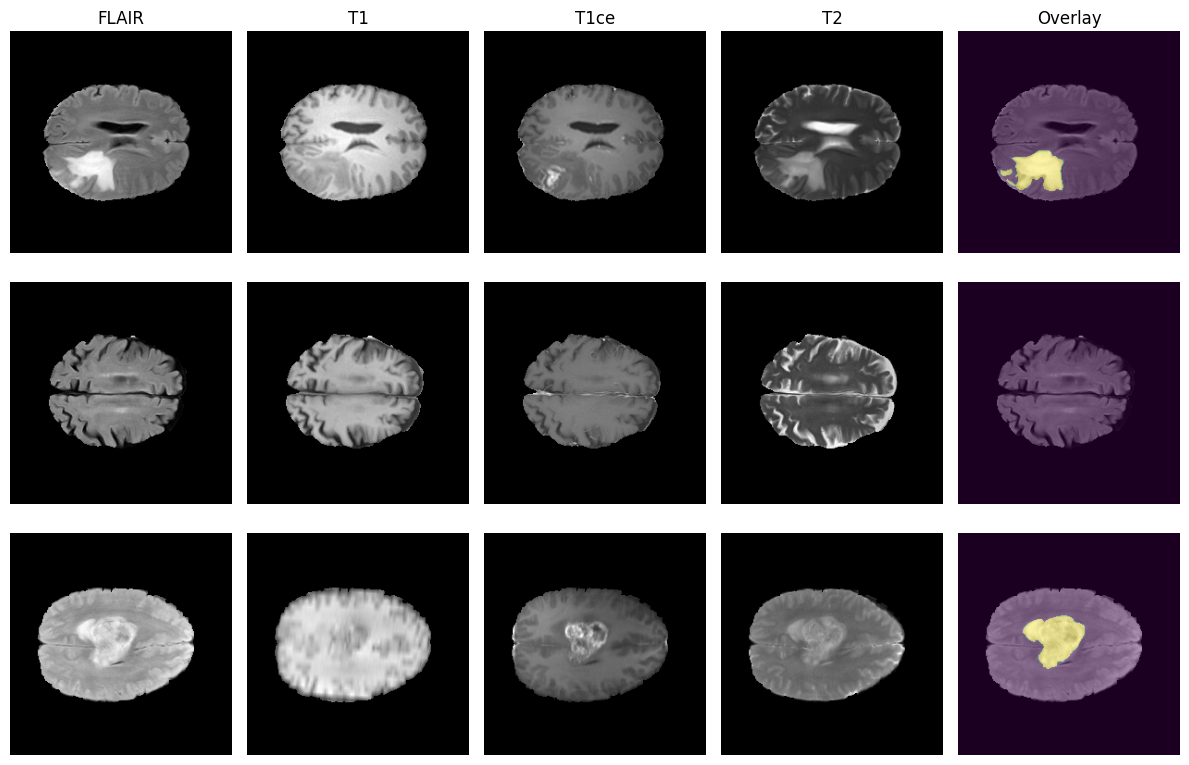

In [2]:
class BraTSSliceDataset(Dataset):
    def __init__(self, root_dir, patient_ids, slice_indices=None, augment=False):
        self.root_dir = root_dir
        self.ids = patient_ids
        self.augment = augment
        self.modalities = ['flair', 't1', 't1ce', 't2']

        self.index_map = []
        for pid in self.ids:
            seg_path = os.path.join(root_dir, pid, f'BraTS20_Training_{pid}_seg.nii')
            depth = nib.load(seg_path).shape[-1]
            slices = slice_indices.get(pid, list(range(depth))) if slice_indices else list(range(depth))
            for z in slices:
                self.index_map.append((pid, z))

        # Compose transforms
        tfms = [T.ToTensor()]
        if augment:
            tfms += [
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                # add T.RandomRotation(15) or albumentations here if you like
            ]
        self.transform = T.Compose(tfms)

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        pid, z = self.index_map[idx]
        imgs = []
        for mod in self.modalities:
            arr = nib.load(
                os.path.join(self.root_dir, pid,
                             f'BraTS20_Training_{pid}_{mod}.nii')
            ).get_fdata()
            slice_img = arr[:, :, z]
            slice_img = (slice_img - slice_img.mean()) / (slice_img.std() + 1e-5)
            imgs.append(slice_img)

        x = np.stack(imgs, axis=-1)            
        mask_arr = nib.load(
            os.path.join(self.root_dir, pid,
                         f'BraTS20_Training_{pid}_seg.nii')
        ).get_fdata()[:, :, z]
        mask = (mask_arr > 0).astype(np.float32)

        # pack and transform
        stacked = np.concatenate([x, mask[..., None]], axis=-1)  
        stacked = self.transform(stacked)                      
        stacked = stacked.float()                          

        return {
            'image': stacked[:4],   
            'mask':  stacked[4]    
        }


root = '/kaggle/input/train-data'
all_ids = sorted(os.listdir(root))
batch_size = 8

# Split patients
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)
slice_map = None 

# Datasets
train_dataset = BraTSSliceDataset(root, train_ids, slice_indices=slice_map or {}, augment=True)
val_dataset   = BraTSSliceDataset(root, val_ids,   slice_indices=slice_map or {}, augment=False)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

print(f"Train slices: {len(train_dataset)}, Train batches: {len(train_dataloader)}")
print(f"Val   slices: {len(val_dataset)},   Val   batches: {len(val_dataloader)}")

# Plot some samples from the first training batch
batch = next(iter(train_dataloader))
images = batch['image'].numpy()   
masks  = batch['mask'].numpy()    

fig, axes = plt.subplots(3, 5, figsize=(12, 8))

col_titles = ['FLAIR', 'T1', 'T1ce', 'T2', 'Overlay']
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title, fontsize=12)

for i in range(3):  
    for m in range(4):  
        ax = axes[i, m]
        ax.imshow(images[i, m], cmap='gray')
        ax.axis('off')
    # Mask overlay on FLAIR
    ax = axes[i, 4]
    ax.imshow(images[i, 0], cmap='gray')
    ax.imshow(masks[i], cmap='viridis', alpha=0.4)
    ax.axis('off')

plt.tight_layout()
plt.show()

# **Model**

In [3]:

class Atrous_Convolution(nn.Module):
    def __init__(
        self,
        input_channels: int,
        kernel_size: int,
        pad: int,
        dilation_rate: int,
        output_channels: int = 256
    ):
        super(Atrous_Convolution, self).__init__()
        # 3×3 atrous conv with specified padding & rate
        self.conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=output_channels,
            kernel_size=kernel_size,
            padding=pad,
            dilation=dilation_rate,
            bias=False
        )
        # follow by BatchNorm and ReLU
        self.bn   = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


In [4]:
class ASSP(nn.Module):
    def __init__(self, in_channles, out_channles):
        super(ASSP, self).__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(in_channles, out_channles, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channles),
            nn.ReLU(inplace=True)
        )

        # three 3x3 atrous conv branches with different dilation rates
        self.conv_6x6  = Atrous_Convolution(
            in_channles, kernel_size=3, pad=6,  dilation_rate=6,  output_channels=out_channles
        )
        self.conv_12x12 = Atrous_Convolution(
            in_channles, kernel_size=3, pad=12, dilation_rate=12, output_channels=out_channles
        )
        self.conv_18x18 = Atrous_Convolution(
            in_channles, kernel_size=3, pad=18, dilation_rate=18, output_channels=out_channles
        )

        # image‐level (global) pooling branch
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channles, out_channles, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channles),
            nn.ReLU(inplace=True)
        )

        # final 1×1 conv to fuse all branches
        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channles * 5, out_channles, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channles),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )

    def forward(self, x):
        # branch 1: 1x1 conv
        x1 = self.conv_1x1(x)
        # branch 2–4: atrous convs
        x2 = self.conv_6x6(x)
        x3 = self.conv_12x12(x)
        x4 = self.conv_18x18(x)
        # branch 5: image pooling → upsample
        x5 = self.image_pool(x)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=False)

        # concatenate along channel dim
        x_cat = torch.cat([x1, x2, x3, x4, x5], dim=1)
        # fuse feature maps
        return self.final_conv(x_cat)


In [5]:
class ResNet_50(nn.Module):
    def __init__(self, output_layer=None, in_channels=3):
        super(ResNet_50, self).__init__()
        # Load a pretrained ResNet50
        self.pretrained = torchvision.models.resnet50(pretrained=True)

        # If we need more than 3 input channels, replace conv1
        if in_channels != 3:
            old = self.pretrained.conv1
            new = nn.Conv2d(
                in_channels,
                old.out_channels,
                kernel_size=old.kernel_size,
                stride=old.stride,
                padding=old.padding,
                bias=False
            )
            # copy weights for the first 3 channels, average for extras
            with torch.no_grad():
                new.weight[:, :3, :, :] = old.weight
                if in_channels > 3:
                    mean_weight = old.weight.mean(dim=1, keepdim=True) 
                    for i in range(3, in_channels):
                        new.weight[:, i:i+1, :, :] = mean_weight
            self.pretrained.conv1 = new

        # Prune off everything after `output_layer`
        self.output_layer = output_layer
        modules = list(self.pretrained._modules.items())
        # find index of the output_layer key
        cut = 0
        for name, _ in modules:
            if name == output_layer:
                break
            cut += 1
        # keep up to and including that layer
        kept = modules[: cut+1]
        self.net = nn.Sequential(*(m for _, m in kept))

        # freeze earlier layers
        for param in self.net.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.net(x)


In [6]:
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(Deeplabv3Plus, self).__init__()

        # now accepts 4‑channel input
        self.backbone = ResNet_50(output_layer='layer3', in_channels=4)
        self.low_level_features = ResNet_50(output_layer='layer1', in_channels=4)

        self.aspp = ASSP(in_channles=1024, out_channles=256)

        # Reduce low‑level features (256→48) with 1×1 conv
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )

        # Decoder: two 3×3 convs on concatenated [256+48]
        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Final classifier
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        H, W = x.shape[2], x.shape[3]

        # — Low‑level features (1/4 resolution) —
        low = self.low_level_features(x)    
        low = self.low_level_conv(low)      

        # — High‑level backbone (1/16 resolution) —
        high = self.backbone(x)             
        x_aspp = self.aspp(high)          

        # upsample ASPP to low‑level’s size
        x_aspp = F.interpolate(
            x_aspp, size=low.shape[2:], mode='bilinear', align_corners=False
        )                                      

        # concat & decode
        x = torch.cat([x_aspp, low], dim=1)    
        x = self.decoder(x)                    

        # upsample to input resolution & classify
        x = F.interpolate(x, size=(H, W),
                          mode='bilinear', align_corners=False)  
        return self.classifier(x)             


# **Loss Functions**

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(weight=weight,
                                             reduction='mean' if size_average else 'sum')

    def forward(self, inputs, targets, smooth=1):
        # BCE part
        bce = self.bce_loss(inputs, targets)

        # Dice part
        probs        = torch.sigmoid(inputs)  # convert logits → probabilities
        probs_flat   = probs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (probs_flat * targets_flat).sum()
        total        = probs_flat.sum() + targets_flat.sum()

        dice_coeff = (2. * intersection + smooth) / (total + smooth)
        dice_loss  = 1 - dice_coeff

        return bce + dice_loss  # combined loss


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        probs        = torch.sigmoid(inputs)  # convert logits → probabilities
        preds        = (probs > 0.5).float()  # threshold to get binary prediction

        preds_flat   = preds.view(-1)
        targets_flat = targets.view(-1)

        intersection = (preds_flat * targets_flat).sum()
        union        = preds_flat.sum() + targets_flat.sum() - intersection

        iou = (intersection + smooth) / (union + smooth)
        return iou


# **Train**

In [8]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False

model = Deeplabv3Plus(num_classes=1).to(DEVICE)
loss_fn = DiceBCELoss()
iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_history = []
train_iou_history = []
train_acc_history = []

val_loss_history = []
val_iou_history = []
val_acc_history = []

best_val_iou = 0.0 

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")

    # TRAINING
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_acc = 0.0
    total_pixels = 0

    batch_loop = tqdm(train_dataloader, total=len(train_dataloader))
    for batch_idx, batch in enumerate(batch_loop):
        imgs = batch['image'].to(DEVICE)       
        masks = batch['mask'].unsqueeze(1).to(DEVICE)  

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  
            outputs = model(imgs)  
            loss = loss_fn(outputs, masks)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # IoU metric
        batch_iou = iou_fn(outputs, masks).item()
        running_iou += batch_iou

        # Accuracy 
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct = (preds == masks).sum().item()
        acc = correct / (masks.numel())
        running_acc += acc

        batch_loop.set_postfix(loss=loss.item(), IoU=batch_iou, Acc=acc)

    # Epoch averages
    epoch_loss = running_loss / len(train_dataloader)
    epoch_iou = running_iou / len(train_dataloader)
    epoch_acc = running_acc / len(train_dataloader)

    train_loss_history.append(epoch_loss)
    train_iou_history.append(epoch_iou)
    train_acc_history.append(epoch_acc)

    print(f"Train Loss: {epoch_loss:.4f} | IoU: {epoch_iou:.4f} | Acc: {epoch_acc:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for batch in val_dataloader:
            imgs = batch['image'].to(DEVICE)
            masks = batch['mask'].unsqueeze(1).to(DEVICE)

            outputs = model(imgs)
            loss = loss_fn(outputs, masks)

            val_loss += loss.item()
            val_iou += iou_fn(outputs, masks).item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct = (preds == masks).sum().item()
            acc = correct / masks.numel()
            val_acc += acc

    val_loss /= len(val_dataloader)
    val_iou /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)
    val_acc_history.append(val_acc)

    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | Val Acc: {val_acc:.4f}")

    # SAVE BEST MODEL
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        print("Saving best model so far (highest IoU)...")
        torch.save({
            "epoch": epoch+1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_iou": val_iou
        }, "best_deeplabv3plus.pth")

    # save latest checkpoint
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, "last_checkpoint.pth")

print("Training completed")




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 
/tmp/ipykernel_36/1577469732.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.Gr


Epoch [1/100]


  0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_36/1577469732.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 36/36 [00:07<00:00,  4.59it/s, Acc=0.971, IoU=0.496, loss=1.09]

Train Loss: 1.3613 | IoU: 0.3394 | Acc: 0.8406


Val Loss: 1.3164 | Val IoU: 0.6294 | Val Acc: 0.9891
Saving best model so far (highest IoU)...

Epoch [2/100]


100%|██████████| 36/36 [00:03<00:00,  9.93it/s, Acc=0.993, IoU=0.746, loss=0.939]

Train Loss: 1.0200 | IoU: 0.6007 | Acc: 0.9845


Val Loss: 0.9409 | Val IoU: 0.7036 | Val Acc: 0.9905
Saving best model so far (highest IoU)...

Epoch [3/100]


100%|██████████| 36/36 [00:03<00:00, 10.37it/s, Acc=0.991, IoU=0.798, loss=0.736]

Train Loss: 0.9078 | IoU: 0.6574 | Acc: 0.9883


Val Loss: 0.8514 | Val IoU: 0.7169 | Val Acc: 0.9908
Saving best model so far (highest IoU)...

Epoch [4/100]


100%|██████████| 36/36 [00:03<00:00, 10.01it/s, Acc=0.988, IoU=0.657, loss=0.795]

Train Loss: 0.8247 | IoU: 0.6909 | Acc: 0.9898


Val Loss: 0.7730 | Val IoU: 0.7353 | Val Acc: 0.9918
Saving best model so far (highest IoU)...

Epoch [5/100]


100%|██████████| 36/36 [00:03<00:00, 10.53it/s, Acc=0.995, IoU=0.863, loss=0.585]

Train Loss: 0.7507 | IoU: 0.7107 | Acc: 0.9908


Val Loss: 0.7023 | Val IoU: 0.7344 | Val Acc: 0.9914

Epoch [6/100]


100%|██████████| 36/36 [00:03<00:00, 10.26it/s, Acc=0.991, IoU=0.549, loss=0.845]

Train Loss: 0.6864 | IoU: 0.7239 | Acc: 0.9917


Val Loss: 0.6638 | Val IoU: 0.6966 | Val Acc: 0.9895

Epoch [7/100]


100%|██████████| 36/36 [00:03<00:00, 10.66it/s, Acc=0.986, IoU=0.606, loss=0.625]

Train Loss: 0.6052 | IoU: 0.7490 | Acc: 0.9925


Val Loss: 0.5595 | Val IoU: 0.7717 | Val Acc: 0.9931
Saving best model so far (highest IoU)...

Epoch [8/100]


100%|██████████| 36/36 [00:03<00:00, 11.23it/s, Acc=0.988, IoU=0.752, loss=0.421]

Train Loss: 0.5342 | IoU: 0.7708 | Acc: 0.9932


Val Loss: 0.4977 | Val IoU: 0.7809 | Val Acc: 0.9936
Saving best model so far (highest IoU)...

Epoch [9/100]


100%|██████████| 36/36 [00:03<00:00, 10.65it/s, Acc=0.99, IoU=0.527, loss=0.689] 

Train Loss: 0.4817 | IoU: 0.7679 | Acc: 0.9934


Val Loss: 0.4406 | Val IoU: 0.7712 | Val Acc: 0.9930

Epoch [10/100]


100%|██████████| 36/36 [00:03<00:00, 10.34it/s, Acc=0.994, IoU=0.881, loss=0.248]

Train Loss: 0.4264 | IoU: 0.7753 | Acc: 0.9936


Val Loss: 0.3996 | Val IoU: 0.7723 | Val Acc: 0.9930

Epoch [11/100]


100%|██████████| 36/36 [00:03<00:00, 10.86it/s, Acc=0.992, IoU=0.268, loss=0.876]

Train Loss: 0.3836 | IoU: 0.7808 | Acc: 0.9939


Val Loss: 0.3531 | Val IoU: 0.7824 | Val Acc: 0.9936
Saving best model so far (highest IoU)...

Epoch [12/100]


100%|██████████| 36/36 [00:03<00:00, 11.24it/s, Acc=0.997, IoU=0.705, loss=0.589]

Train Loss: 0.3396 | IoU: 0.7977 | Acc: 0.9944


Val Loss: 0.3164 | Val IoU: 0.7913 | Val Acc: 0.9940
Saving best model so far (highest IoU)...

Epoch [13/100]


100%|██████████| 36/36 [00:03<00:00, 11.18it/s, Acc=0.997, IoU=0.881, loss=0.227]

Train Loss: 0.2941 | IoU: 0.8183 | Acc: 0.9950


Val Loss: 0.2819 | Val IoU: 0.7918 | Val Acc: 0.9941
Saving best model so far (highest IoU)...

Epoch [14/100]


100%|██████████| 36/36 [00:03<00:00, 11.26it/s, Acc=0.986, IoU=0.000422, loss=1.07]

Train Loss: 0.2895 | IoU: 0.7942 | Acc: 0.9947


Val Loss: 0.2612 | Val IoU: 0.7964 | Val Acc: 0.9940
Saving best model so far (highest IoU)...

Epoch [15/100]


100%|██████████| 36/36 [00:03<00:00, 11.34it/s, Acc=0.998, IoU=0.894, loss=0.196]

Train Loss: 0.2398 | IoU: 0.8278 | Acc: 0.9953


Val Loss: 0.2505 | Val IoU: 0.7862 | Val Acc: 0.9940

Epoch [16/100]


100%|██████████| 36/36 [00:03<00:00, 11.03it/s, Acc=0.996, IoU=0.0794, loss=0.999]

Train Loss: 0.2505 | IoU: 0.7999 | Acc: 0.9952


Val Loss: 0.2213 | Val IoU: 0.8012 | Val Acc: 0.9942
Saving best model so far (highest IoU)...

Epoch [17/100]


100%|██████████| 36/36 [00:03<00:00, 11.22it/s, Acc=0.997, IoU=0.886, loss=0.152]

Train Loss: 0.2258 | IoU: 0.8136 | Acc: 0.9951


Val Loss: 0.2207 | Val IoU: 0.7946 | Val Acc: 0.9942

Epoch [18/100]


100%|██████████| 36/36 [00:03<00:00, 11.06it/s, Acc=0.995, IoU=0.726, loss=0.287]

Train Loss: 0.1869 | IoU: 0.8421 | Acc: 0.9957


Val Loss: 0.1985 | Val IoU: 0.8085 | Val Acc: 0.9945
Saving best model so far (highest IoU)...

Epoch [19/100]


100%|██████████| 36/36 [00:03<00:00, 11.23it/s, Acc=0.994, IoU=0.751, loss=0.238]

Train Loss: 0.1924 | IoU: 0.8230 | Acc: 0.9954


Val Loss: 0.1922 | Val IoU: 0.8077 | Val Acc: 0.9945

Epoch [20/100]


100%|██████████| 36/36 [00:03<00:00, 10.97it/s, Acc=0.996, IoU=0.889, loss=0.123]

Train Loss: 0.1624 | IoU: 0.8503 | Acc: 0.9959


Val Loss: 0.1832 | Val IoU: 0.8116 | Val Acc: 0.9947
Saving best model so far (highest IoU)...

Epoch [21/100]


100%|██████████| 36/36 [00:03<00:00, 10.82it/s, Acc=0.997, IoU=0.855, loss=0.157]

Train Loss: 0.1604 | IoU: 0.8494 | Acc: 0.9960


Val Loss: 0.1985 | Val IoU: 0.7787 | Val Acc: 0.9932

Epoch [22/100]


100%|██████████| 36/36 [00:03<00:00, 11.39it/s, Acc=0.993, IoU=0.773, loss=0.195]

Train Loss: 0.1597 | IoU: 0.8385 | Acc: 0.9957


Val Loss: 0.1689 | Val IoU: 0.8124 | Val Acc: 0.9947
Saving best model so far (highest IoU)...

Epoch [23/100]


100%|██████████| 36/36 [00:03<00:00, 11.22it/s, Acc=0.997, IoU=0.72, loss=0.274] 

Train Loss: 0.1513 | IoU: 0.8439 | Acc: 0.9959


Val Loss: 0.1915 | Val IoU: 0.7753 | Val Acc: 0.9938

Epoch [24/100]


100%|██████████| 36/36 [00:03<00:00, 11.34it/s, Acc=0.997, IoU=0.889, loss=0.11]  

Train Loss: 0.1414 | IoU: 0.8500 | Acc: 0.9960


Val Loss: 0.1687 | Val IoU: 0.8028 | Val Acc: 0.9944

Epoch [25/100]


100%|██████████| 36/36 [00:03<00:00, 11.46it/s, Acc=0.996, IoU=0.897, loss=0.0934]

Train Loss: 0.1371 | IoU: 0.8544 | Acc: 0.9962


Val Loss: 0.1590 | Val IoU: 0.8123 | Val Acc: 0.9947

Epoch [26/100]


100%|██████████| 36/36 [00:03<00:00, 11.27it/s, Acc=0.995, IoU=0.877, loss=0.108] 

Train Loss: 0.1259 | IoU: 0.8626 | Acc: 0.9963


Val Loss: 0.1597 | Val IoU: 0.8093 | Val Acc: 0.9946

Epoch [27/100]


100%|██████████| 36/36 [00:03<00:00, 11.12it/s, Acc=0.991, IoU=0.88, loss=0.105]  

Train Loss: 0.1348 | IoU: 0.8490 | Acc: 0.9959


Val Loss: 0.1526 | Val IoU: 0.8126 | Val Acc: 0.9947
Saving best model so far (highest IoU)...

Epoch [28/100]


100%|██████████| 36/36 [00:03<00:00, 11.14it/s, Acc=0.995, IoU=0.891, loss=0.0963]

Train Loss: 0.1409 | IoU: 0.8484 | Acc: 0.9961


Val Loss: 0.1645 | Val IoU: 0.7935 | Val Acc: 0.9939

Epoch [29/100]


100%|██████████| 36/36 [00:03<00:00, 10.80it/s, Acc=0.999, IoU=0.93, loss=0.0734] 

Train Loss: 0.1190 | IoU: 0.8628 | Acc: 0.9964


Val Loss: 0.1599 | Val IoU: 0.8019 | Val Acc: 0.9944

Epoch [30/100]


100%|██████████| 36/36 [00:03<00:00, 11.23it/s, Acc=0.999, IoU=0.00625, loss=1.01]

Train Loss: 0.1385 | IoU: 0.8428 | Acc: 0.9965


Val Loss: 0.1438 | Val IoU: 0.8207 | Val Acc: 0.9949
Saving best model so far (highest IoU)...

Epoch [31/100]


100%|██████████| 36/36 [00:03<00:00, 10.96it/s, Acc=0.997, IoU=0.926, loss=0.0681]

Train Loss: 0.1151 | IoU: 0.8675 | Acc: 0.9965


Val Loss: 0.1484 | Val IoU: 0.8106 | Val Acc: 0.9945

Epoch [32/100]


100%|██████████| 36/36 [00:03<00:00, 11.19it/s, Acc=0.999, IoU=0.869, loss=0.141] 

Train Loss: 0.1125 | IoU: 0.8663 | Acc: 0.9966


Val Loss: 0.1478 | Val IoU: 0.8123 | Val Acc: 0.9948

Epoch [33/100]


100%|██████████| 36/36 [00:03<00:00, 10.65it/s, Acc=0.995, IoU=0.721, loss=0.219] 

Train Loss: 0.1114 | IoU: 0.8647 | Acc: 0.9964


Val Loss: 0.1414 | Val IoU: 0.8183 | Val Acc: 0.9948

Epoch [34/100]


100%|██████████| 36/36 [00:03<00:00, 10.82it/s, Acc=0.998, IoU=0.911, loss=0.077] 

Train Loss: 0.1054 | IoU: 0.8717 | Acc: 0.9966


Val Loss: 0.1489 | Val IoU: 0.8060 | Val Acc: 0.9945

Epoch [35/100]


100%|██████████| 36/36 [00:03<00:00, 10.76it/s, Acc=0.997, IoU=0.671, loss=0.272] 

Train Loss: 0.1107 | IoU: 0.8636 | Acc: 0.9966


Val Loss: 0.1420 | Val IoU: 0.8155 | Val Acc: 0.9948

Epoch [36/100]


100%|██████████| 36/36 [00:03<00:00, 10.58it/s, Acc=0.999, IoU=0.00658, loss=1]   

Train Loss: 0.1288 | IoU: 0.8471 | Acc: 0.9966


Val Loss: 0.1389 | Val IoU: 0.8166 | Val Acc: 0.9948

Epoch [37/100]


100%|██████████| 36/36 [00:03<00:00, 10.68it/s, Acc=0.998, IoU=0.864, loss=0.11]  

Train Loss: 0.0989 | IoU: 0.8763 | Acc: 0.9968


Val Loss: 0.1434 | Val IoU: 0.8122 | Val Acc: 0.9947

Epoch [38/100]


100%|██████████| 36/36 [00:03<00:00, 10.61it/s, Acc=0.996, IoU=0.717, loss=0.218] 

Train Loss: 0.1034 | IoU: 0.8703 | Acc: 0.9968


Val Loss: 0.1533 | Val IoU: 0.7972 | Val Acc: 0.9943

Epoch [39/100]


100%|██████████| 36/36 [00:03<00:00, 10.01it/s, Acc=0.997, IoU=0.92, loss=0.0665] 

Train Loss: 0.0939 | IoU: 0.8818 | Acc: 0.9969


Val Loss: 0.1447 | Val IoU: 0.8075 | Val Acc: 0.9946

Epoch [40/100]


100%|██████████| 36/36 [00:03<00:00, 10.60it/s, Acc=0.997, IoU=0.73, loss=0.209]  

Train Loss: 0.0939 | IoU: 0.8794 | Acc: 0.9969


Val Loss: 0.1324 | Val IoU: 0.8246 | Val Acc: 0.9950
Saving best model so far (highest IoU)...

Epoch [41/100]


100%|██████████| 36/36 [00:03<00:00, 10.76it/s, Acc=0.997, IoU=0.896, loss=0.0801]

Train Loss: 0.0895 | IoU: 0.8849 | Acc: 0.9970


Val Loss: 0.1349 | Val IoU: 0.8177 | Val Acc: 0.9948

Epoch [42/100]


100%|██████████| 36/36 [00:03<00:00, 10.56it/s, Acc=0.999, IoU=0.869, loss=0.119] 

Train Loss: 0.0982 | IoU: 0.8723 | Acc: 0.9967


Val Loss: 0.1315 | Val IoU: 0.8227 | Val Acc: 0.9949

Epoch [43/100]


100%|██████████| 36/36 [00:03<00:00, 11.00it/s, Acc=0.999, IoU=0.00917, loss=1]   

Train Loss: 0.1136 | IoU: 0.8611 | Acc: 0.9970


Val Loss: 0.1455 | Val IoU: 0.8047 | Val Acc: 0.9945

Epoch [44/100]


100%|██████████| 36/36 [00:03<00:00, 10.33it/s, Acc=0.997, IoU=0.823, loss=0.127] 

Train Loss: 0.0831 | IoU: 0.8921 | Acc: 0.9971


Val Loss: 0.1309 | Val IoU: 0.8227 | Val Acc: 0.9949

Epoch [45/100]


100%|██████████| 36/36 [00:03<00:00,  9.88it/s, Acc=0.997, IoU=0.902, loss=0.0712]

Train Loss: 0.0864 | IoU: 0.8868 | Acc: 0.9971


Val Loss: 0.1553 | Val IoU: 0.7902 | Val Acc: 0.9941

Epoch [46/100]


100%|██████████| 36/36 [00:03<00:00, 10.79it/s, Acc=0.999, IoU=0.781, loss=0.196] 

Train Loss: 0.0955 | IoU: 0.8741 | Acc: 0.9968


Val Loss: 0.1300 | Val IoU: 0.8228 | Val Acc: 0.9949

Epoch [47/100]


100%|██████████| 36/36 [00:03<00:00, 10.89it/s, Acc=0.996, IoU=0.904, loss=0.0772]

Train Loss: 0.0821 | IoU: 0.8931 | Acc: 0.9971


Val Loss: 0.1220 | Val IoU: 0.8333 | Val Acc: 0.9952
Saving best model so far (highest IoU)...

Epoch [48/100]


100%|██████████| 36/36 [00:03<00:00, 10.74it/s, Acc=0.993, IoU=0.884, loss=0.0919]

Train Loss: 0.0807 | IoU: 0.8925 | Acc: 0.9971


Val Loss: 0.1283 | Val IoU: 0.8243 | Val Acc: 0.9950

Epoch [49/100]


100%|██████████| 36/36 [00:03<00:00, 10.62it/s, Acc=0.996, IoU=0.868, loss=0.0936]

Train Loss: 0.0838 | IoU: 0.8875 | Acc: 0.9971


Val Loss: 0.1304 | Val IoU: 0.8206 | Val Acc: 0.9949

Epoch [50/100]


100%|██████████| 36/36 [00:03<00:00, 10.73it/s, Acc=0.996, IoU=0.898, loss=0.0756]

Train Loss: 0.0843 | IoU: 0.8869 | Acc: 0.9971


Val Loss: 0.1348 | Val IoU: 0.8142 | Val Acc: 0.9947

Epoch [51/100]


100%|██████████| 36/36 [00:03<00:00, 10.32it/s, Acc=0.995, IoU=0.88, loss=0.0921] 

Train Loss: 0.0765 | IoU: 0.8972 | Acc: 0.9973


Val Loss: 0.1259 | Val IoU: 0.8261 | Val Acc: 0.9950

Epoch [52/100]


100%|██████████| 36/36 [00:03<00:00, 10.92it/s, Acc=0.998, IoU=0.856, loss=0.105] 

Train Loss: 0.0808 | IoU: 0.8901 | Acc: 0.9972


Val Loss: 0.1277 | Val IoU: 0.8238 | Val Acc: 0.9950

Epoch [53/100]


100%|██████████| 36/36 [00:03<00:00, 10.85it/s, Acc=0.995, IoU=0.823, loss=0.132] 

Train Loss: 0.0825 | IoU: 0.8879 | Acc: 0.9971


Val Loss: 0.1285 | Val IoU: 0.8224 | Val Acc: 0.9949

Epoch [54/100]


100%|██████████| 36/36 [00:03<00:00, 10.91it/s, Acc=0.995, IoU=0.319, loss=0.616] 

Train Loss: 0.0931 | IoU: 0.8772 | Acc: 0.9972


Val Loss: 0.1267 | Val IoU: 0.8265 | Val Acc: 0.9951

Epoch [55/100]


100%|██████████| 36/36 [00:03<00:00, 10.82it/s, Acc=0.998, IoU=0.931, loss=0.0544]

Train Loss: 0.0827 | IoU: 0.8903 | Acc: 0.9971


Val Loss: 0.1277 | Val IoU: 0.8244 | Val Acc: 0.9950

Epoch [56/100]


100%|██████████| 36/36 [00:03<00:00, 10.67it/s, Acc=0.991, IoU=0.777, loss=0.163] 

Train Loss: 0.0812 | IoU: 0.8893 | Acc: 0.9971


Val Loss: 0.1236 | Val IoU: 0.8293 | Val Acc: 0.9951

Epoch [57/100]


100%|██████████| 36/36 [00:03<00:00,  9.92it/s, Acc=0.999, IoU=0.805, loss=0.199] 

Train Loss: 0.0817 | IoU: 0.8890 | Acc: 0.9972


Val Loss: 0.1306 | Val IoU: 0.8218 | Val Acc: 0.9949

Epoch [58/100]


100%|██████████| 36/36 [00:03<00:00, 10.76it/s, Acc=0.998, IoU=0.89, loss=0.0784] 

Train Loss: 0.0770 | IoU: 0.8942 | Acc: 0.9972


Val Loss: 0.1223 | Val IoU: 0.8294 | Val Acc: 0.9951

Epoch [59/100]


100%|██████████| 36/36 [00:03<00:00, 10.78it/s, Acc=0.996, IoU=0.921, loss=0.06]  

Train Loss: 0.0745 | IoU: 0.8969 | Acc: 0.9973


Val Loss: 0.1248 | Val IoU: 0.8263 | Val Acc: 0.9951

Epoch [60/100]


100%|██████████| 36/36 [00:03<00:00, 10.68it/s, Acc=0.999, IoU=0.933, loss=0.0497]

Train Loss: 0.0760 | IoU: 0.8943 | Acc: 0.9972


Val Loss: 0.1234 | Val IoU: 0.8291 | Val Acc: 0.9952

Epoch [61/100]


100%|██████████| 36/36 [00:03<00:00, 11.28it/s, Acc=0.996, IoU=0.877, loss=0.0881]

Train Loss: 0.0724 | IoU: 0.8994 | Acc: 0.9973


Val Loss: 0.1211 | Val IoU: 0.8315 | Val Acc: 0.9951

Epoch [62/100]


100%|██████████| 36/36 [00:03<00:00, 10.89it/s, Acc=0.997, IoU=0.9, loss=0.0721]  

Train Loss: 0.0733 | IoU: 0.8982 | Acc: 0.9974


Val Loss: 0.1238 | Val IoU: 0.8261 | Val Acc: 0.9951

Epoch [63/100]


100%|██████████| 36/36 [00:03<00:00,  9.92it/s, Acc=0.998, IoU=0.877, loss=0.0858]

Train Loss: 0.0737 | IoU: 0.8971 | Acc: 0.9974


Val Loss: 0.1228 | Val IoU: 0.8308 | Val Acc: 0.9952

Epoch [64/100]


100%|██████████| 36/36 [00:03<00:00, 10.85it/s, Acc=0.998, IoU=0.946, loss=0.0425]

Train Loss: 0.0739 | IoU: 0.8963 | Acc: 0.9973


Val Loss: 0.1247 | Val IoU: 0.8243 | Val Acc: 0.9950

Epoch [65/100]


100%|██████████| 36/36 [00:03<00:00, 10.94it/s, Acc=0.993, IoU=0.884, loss=0.0925]

Train Loss: 0.0760 | IoU: 0.8939 | Acc: 0.9972


Val Loss: 0.1200 | Val IoU: 0.8314 | Val Acc: 0.9952

Epoch [66/100]


100%|██████████| 36/36 [00:03<00:00, 10.67it/s, Acc=0.996, IoU=0.825, loss=0.124] 

Train Loss: 0.0843 | IoU: 0.8833 | Acc: 0.9971


Val Loss: 0.1216 | Val IoU: 0.8301 | Val Acc: 0.9951

Epoch [67/100]


100%|██████████| 36/36 [00:03<00:00, 10.99it/s, Acc=0.996, IoU=0.776, loss=0.155] 

Train Loss: 0.0737 | IoU: 0.8960 | Acc: 0.9973


Val Loss: 0.1259 | Val IoU: 0.8248 | Val Acc: 0.9950

Epoch [68/100]


100%|██████████| 36/36 [00:03<00:00, 10.73it/s, Acc=0.997, IoU=0.879, loss=0.0845]

Train Loss: 0.0699 | IoU: 0.9016 | Acc: 0.9974


Val Loss: 0.1225 | Val IoU: 0.8285 | Val Acc: 0.9951

Epoch [69/100]


100%|██████████| 36/36 [00:03<00:00, 10.14it/s, Acc=0.998, IoU=0.868, loss=0.0885]

Train Loss: 0.0688 | IoU: 0.9022 | Acc: 0.9975


Val Loss: 0.1277 | Val IoU: 0.8222 | Val Acc: 0.9950

Epoch [70/100]


100%|██████████| 36/36 [00:03<00:00, 10.59it/s, Acc=1, IoU=0.027, loss=0.996]     

Train Loss: 0.0944 | IoU: 0.8788 | Acc: 0.9975


Val Loss: 0.1225 | Val IoU: 0.8296 | Val Acc: 0.9952

Epoch [71/100]


100%|██████████| 36/36 [00:03<00:00, 10.82it/s, Acc=0.996, IoU=0.896, loss=0.0735]

Train Loss: 0.0668 | IoU: 0.9060 | Acc: 0.9975


Val Loss: 0.1153 | Val IoU: 0.8374 | Val Acc: 0.9953
Saving best model so far (highest IoU)...

Epoch [72/100]


100%|██████████| 36/36 [00:03<00:00, 10.55it/s, Acc=0.998, IoU=0.935, loss=0.0468]

Train Loss: 0.0682 | IoU: 0.9031 | Acc: 0.9975


Val Loss: 0.1184 | Val IoU: 0.8336 | Val Acc: 0.9953

Epoch [73/100]


100%|██████████| 36/36 [00:03<00:00, 10.63it/s, Acc=0.998, IoU=0.889, loss=0.0776]

Train Loss: 0.0671 | IoU: 0.9046 | Acc: 0.9976


Val Loss: 0.1217 | Val IoU: 0.8297 | Val Acc: 0.9952

Epoch [74/100]


100%|██████████| 36/36 [00:03<00:00, 10.62it/s, Acc=0.998, IoU=0.924, loss=0.0579]

Train Loss: 0.0654 | IoU: 0.9080 | Acc: 0.9976


Val Loss: 0.1164 | Val IoU: 0.8374 | Val Acc: 0.9954
Saving best model so far (highest IoU)...

Epoch [75/100]


100%|██████████| 36/36 [00:03<00:00,  9.78it/s, Acc=0.998, IoU=0.915, loss=0.0578]

Train Loss: 0.0667 | IoU: 0.9055 | Acc: 0.9976


Val Loss: 0.1145 | Val IoU: 0.8394 | Val Acc: 0.9954
Saving best model so far (highest IoU)...

Epoch [76/100]


100%|██████████| 36/36 [00:03<00:00, 10.10it/s, Acc=0.997, IoU=0.921, loss=0.0598]

Train Loss: 0.0646 | IoU: 0.9080 | Acc: 0.9976


Val Loss: 0.1189 | Val IoU: 0.8337 | Val Acc: 0.9953

Epoch [77/100]


100%|██████████| 36/36 [00:03<00:00, 10.56it/s, Acc=0.996, IoU=0.906, loss=0.0686]

Train Loss: 0.0676 | IoU: 0.9043 | Acc: 0.9975


Val Loss: 0.1197 | Val IoU: 0.8332 | Val Acc: 0.9953

Epoch [78/100]


100%|██████████| 36/36 [00:03<00:00,  9.01it/s, Acc=0.996, IoU=0.813, loss=0.127] 

Train Loss: 0.0661 | IoU: 0.9058 | Acc: 0.9976


Val Loss: 0.1203 | Val IoU: 0.8302 | Val Acc: 0.9951

Epoch [79/100]


100%|██████████| 36/36 [00:03<00:00, 10.75it/s, Acc=0.995, IoU=0.83, loss=0.123]  

Train Loss: 0.0644 | IoU: 0.9079 | Acc: 0.9976


Val Loss: 0.1241 | Val IoU: 0.8274 | Val Acc: 0.9951

Epoch [80/100]


100%|██████████| 36/36 [00:03<00:00, 10.66it/s, Acc=0.998, IoU=0.852, loss=0.105] 

Train Loss: 0.0642 | IoU: 0.9083 | Acc: 0.9976


Val Loss: 0.1159 | Val IoU: 0.8383 | Val Acc: 0.9954

Epoch [81/100]


100%|██████████| 36/36 [00:03<00:00, 10.39it/s, Acc=0.999, IoU=0.808, loss=0.134] 

Train Loss: 0.0691 | IoU: 0.9015 | Acc: 0.9975


Val Loss: 0.1231 | Val IoU: 0.8279 | Val Acc: 0.9951

Epoch [82/100]


100%|██████████| 36/36 [00:03<00:00, 10.49it/s, Acc=0.995, IoU=0.876, loss=0.0881]

Train Loss: 0.0642 | IoU: 0.9082 | Acc: 0.9975


Val Loss: 0.1159 | Val IoU: 0.8363 | Val Acc: 0.9954

Epoch [83/100]


100%|██████████| 36/36 [00:03<00:00, 10.73it/s, Acc=0.996, IoU=0.858, loss=0.0987]

Train Loss: 0.0632 | IoU: 0.9090 | Acc: 0.9976


Val Loss: 0.1181 | Val IoU: 0.8354 | Val Acc: 0.9953

Epoch [84/100]


100%|██████████| 36/36 [00:03<00:00, 10.44it/s, Acc=0.998, IoU=0.933, loss=0.0478]

Train Loss: 0.0616 | IoU: 0.9115 | Acc: 0.9977


Val Loss: 0.1178 | Val IoU: 0.8350 | Val Acc: 0.9953

Epoch [85/100]


100%|██████████| 36/36 [00:03<00:00, 10.78it/s, Acc=0.998, IoU=0.93, loss=0.0497] 

Train Loss: 0.0607 | IoU: 0.9128 | Acc: 0.9977


Val Loss: 0.1239 | Val IoU: 0.8275 | Val Acc: 0.9951

Epoch [86/100]


100%|██████████| 36/36 [00:03<00:00, 10.66it/s, Acc=0.997, IoU=0.904, loss=0.0692]

Train Loss: 0.0662 | IoU: 0.9043 | Acc: 0.9976


Val Loss: 0.1208 | Val IoU: 0.8326 | Val Acc: 0.9952

Epoch [87/100]


100%|██████████| 36/36 [00:03<00:00, 10.72it/s, Acc=0.999, IoU=0.931, loss=0.0467]

Train Loss: 0.0636 | IoU: 0.9078 | Acc: 0.9976


Val Loss: 0.1172 | Val IoU: 0.8359 | Val Acc: 0.9953

Epoch [88/100]


100%|██████████| 36/36 [00:03<00:00, 10.51it/s, Acc=0.995, IoU=0.895, loss=0.0822]

Train Loss: 0.0619 | IoU: 0.9109 | Acc: 0.9977


Val Loss: 0.1187 | Val IoU: 0.8336 | Val Acc: 0.9952

Epoch [89/100]


100%|██████████| 36/36 [00:03<00:00, 10.57it/s, Acc=0.998, IoU=0.84, loss=0.105]  

Train Loss: 0.0610 | IoU: 0.9116 | Acc: 0.9977


Val Loss: 0.1220 | Val IoU: 0.8295 | Val Acc: 0.9951

Epoch [90/100]


100%|██████████| 36/36 [00:03<00:00, 11.34it/s, Acc=0.996, IoU=0.936, loss=0.0546]

Train Loss: 0.0610 | IoU: 0.9117 | Acc: 0.9977


Val Loss: 0.1196 | Val IoU: 0.8310 | Val Acc: 0.9952

Epoch [91/100]


100%|██████████| 36/36 [00:03<00:00, 11.29it/s, Acc=0.997, IoU=0.854, loss=0.0993]

Train Loss: 0.0632 | IoU: 0.9079 | Acc: 0.9976


Val Loss: 0.1189 | Val IoU: 0.8328 | Val Acc: 0.9952

Epoch [92/100]


100%|██████████| 36/36 [00:03<00:00, 11.16it/s, Acc=0.998, IoU=0.942, loss=0.0425]

Train Loss: 0.0591 | IoU: 0.9144 | Acc: 0.9977


Val Loss: 0.1171 | Val IoU: 0.8358 | Val Acc: 0.9953

Epoch [93/100]


100%|██████████| 36/36 [00:03<00:00, 11.08it/s, Acc=0.998, IoU=0.908, loss=0.0607]

Train Loss: 0.0607 | IoU: 0.9117 | Acc: 0.9978


Val Loss: 0.1236 | Val IoU: 0.8283 | Val Acc: 0.9951

Epoch [94/100]


100%|██████████| 36/36 [00:03<00:00, 11.09it/s, Acc=0.998, IoU=0.835, loss=0.114] 

Train Loss: 0.0629 | IoU: 0.9088 | Acc: 0.9977


Val Loss: 0.1224 | Val IoU: 0.8303 | Val Acc: 0.9951

Epoch [95/100]


100%|██████████| 36/36 [00:03<00:00, 11.14it/s, Acc=0.998, IoU=0.906, loss=0.0651]

Train Loss: 0.0632 | IoU: 0.9083 | Acc: 0.9977


Val Loss: 0.1190 | Val IoU: 0.8344 | Val Acc: 0.9952

Epoch [96/100]


100%|██████████| 36/36 [00:03<00:00, 11.35it/s, Acc=0.998, IoU=0.912, loss=0.0584]

Train Loss: 0.0628 | IoU: 0.9086 | Acc: 0.9977


Val Loss: 0.1285 | Val IoU: 0.8235 | Val Acc: 0.9950

Epoch [97/100]


100%|██████████| 36/36 [00:03<00:00, 10.79it/s, Acc=0.998, IoU=0.913, loss=0.0549]

Train Loss: 0.0625 | IoU: 0.9097 | Acc: 0.9977


Val Loss: 0.1324 | Val IoU: 0.8156 | Val Acc: 0.9948

Epoch [98/100]


100%|██████████| 36/36 [00:03<00:00, 10.88it/s, Acc=0.997, IoU=0.906, loss=0.065] 

Train Loss: 0.0628 | IoU: 0.9088 | Acc: 0.9976


Val Loss: 0.1174 | Val IoU: 0.8350 | Val Acc: 0.9952

Epoch [99/100]


100%|██████████| 36/36 [00:03<00:00,  9.98it/s, Acc=0.997, IoU=0.899, loss=0.0712]

Train Loss: 0.0596 | IoU: 0.9131 | Acc: 0.9977


Val Loss: 0.1153 | Val IoU: 0.8370 | Val Acc: 0.9953

Epoch [100/100]


100%|██████████| 36/36 [00:03<00:00, 10.90it/s, Acc=0.998, IoU=0.942, loss=0.0406]

Train Loss: 0.0624 | IoU: 0.9094 | Acc: 0.9977


Val Loss: 0.1190 | Val IoU: 0.8336 | Val Acc: 0.9952
Training completed


# **Training Curves**

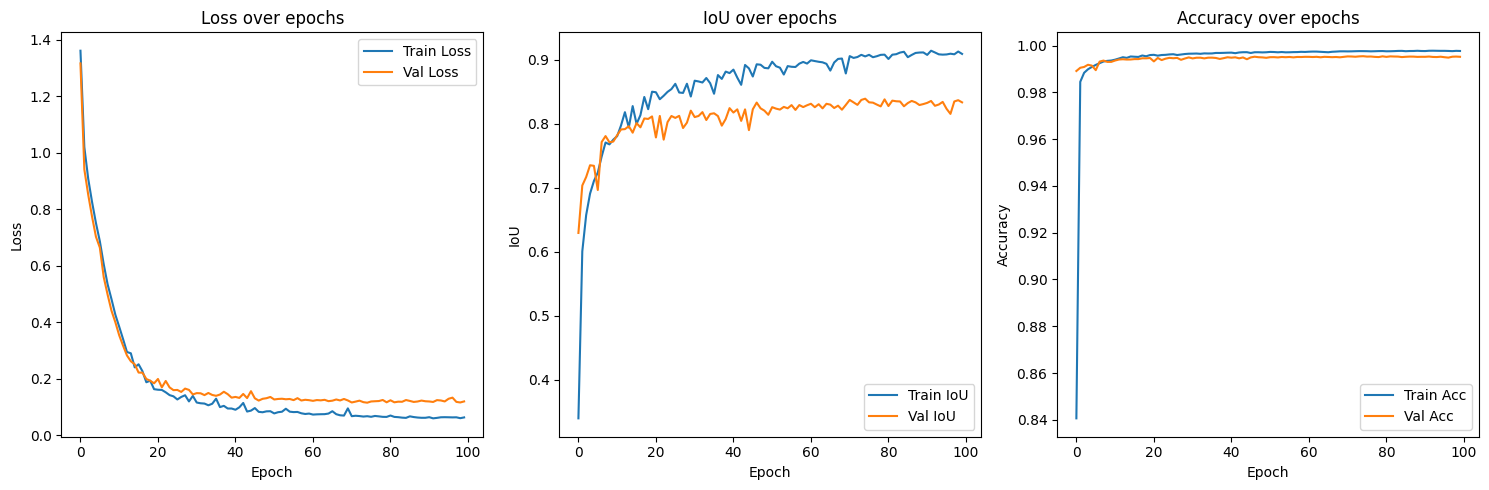

In [9]:
plt.figure(figsize=(15,5))

# Loss curves
plt.subplot(1,3,1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()

# IoU curves
plt.subplot(1,3,2)
plt.plot(train_iou_history, label="Train IoU")
plt.plot(val_iou_history, label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU over epochs")
plt.legend()

# Accuracy curves
plt.subplot(1,3,3)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

plt.tight_layout()
plt.show()

# **Evaluation**

Loaded best model with Val IoU = 0.8394
Evaluation on Validation Set:
   Mean IoU:   0.7728
   Accuracy:   0.9954
   Dice Score: 0.8367


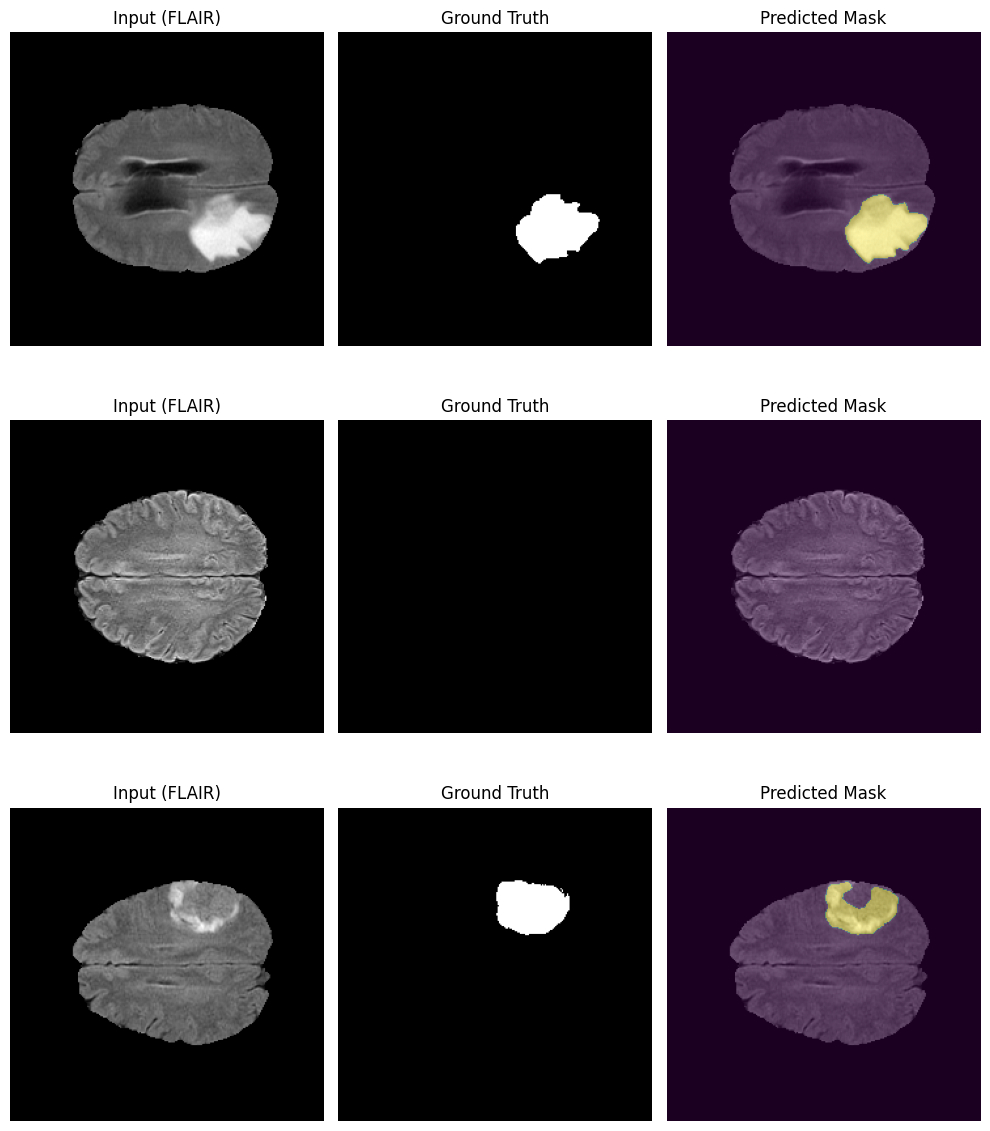

In [10]:
def evaluate_model(model_path="best_deeplabv3plus.pth"):
    # Load best model checkpoint
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    print(f"Loaded best model with Val IoU = {checkpoint['val_iou']:.4f}")

    total_iou = 0.0
    total_acc = 0.0
    total_dice = 0.0
    total_batches = 0

    sample_images = []
    sample_gt_masks = []
    sample_preds = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            imgs = batch['image'].to(DEVICE)
            masks = batch['mask'].unsqueeze(1).to(DEVICE)

            outputs = model(imgs) 
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # IoU
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = (preds + masks - preds * masks).sum(dim=(1,2,3))
            batch_iou = ((intersection + 1e-6) / (union + 1e-6)).mean().item()

            # Accuracy
            correct = (preds == masks).sum().item()
            acc = correct / masks.numel()

            # Dice score
            dice = (2 * intersection + 1e-6) / (preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) + 1e-6)
            dice = dice.mean().item()

            total_iou += batch_iou
            total_acc += acc
            total_dice += dice
            total_batches += 1

            # Save 1st batch as sample for visualization
            if batch_idx == 0:
                sample_images = imgs.cpu()
                sample_gt_masks = masks.cpu()
                sample_preds = preds.cpu()

    # Aggregate metrics
    avg_iou = total_iou / total_batches
    avg_acc = total_acc / total_batches
    avg_dice = total_dice / total_batches

    print(f"Evaluation on Validation Set:")
    print(f"   Mean IoU:   {avg_iou:.4f}")
    print(f"   Accuracy:   {avg_acc:.4f}")
    print(f"   Dice Score: {avg_dice:.4f}")

    # Plot sample outputs
    num_samples_to_show = min(3, sample_images.shape[0])
    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(10, num_samples_to_show * 4))

    for i in range(num_samples_to_show):
        flair_img = sample_images[i, 0]  
        gt_mask = sample_gt_masks[i, 0]  
        pred_mask = sample_preds[i, 0] 

        if num_samples_to_show == 1:
            ax1, ax2, ax3 = axes
        else:
            ax1, ax2, ax3 = axes[i]

        ax1.imshow(flair_img, cmap='gray')
        ax1.set_title("Input (FLAIR)")
        ax1.axis('off')

        ax2.imshow(gt_mask, cmap='gray')
        ax2.set_title("Ground Truth")
        ax2.axis('off')

        ax3.imshow(flair_img, cmap='gray')
        ax3.imshow(pred_mask, cmap='viridis', alpha=0.4)
        ax3.set_title("Predicted Mask")
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

    return avg_iou, avg_acc, avg_dice

avg_iou, avg_acc, avg_dice = evaluate_model("best_deeplabv3plus.pth")


# **Result Analysis**

The DeepLabv3+ model was trained for brain tumor segmentation on MRI FLAIR images using the DiceBCE loss function. The model performance was evaluated through **loss, IoU (Intersection over Union), accuracy**, and **Dice score** on both training and validation sets.

## 1. Training and Validation Curves

* **Loss Curve:**

  * Both training and validation losses show a steep decline in the first epochs, stabilizing around **0.1–0.15 for validation**.
  * The curves remain close without a significant gap, suggesting **minimal overfitting and good generalization**.

* **IoU Curve:**

  * The IoU metric increased steadily, reaching **\~0.90 for training** and **\~0.83 for validation**.
  * The slight gap between training and validation IoU indicates a small amount of generalization error, but the validation IoU remains high.

* **Accuracy Curve:**

  * Accuracy quickly rose above **99% for both training and validation**.
  * However, since most of the image area is background, accuracy is less informative compared to IoU and Dice scores for tumor segmentation.

## 2. Quantitative Metrics on the Best Model

The best checkpoint, selected based on highest validation IoU (**0.8394**), achieved:

* **Mean IoU:** 0.7728
* **Accuracy:** 0.9954
* **Dice Score:** 0.8367

These metrics confirm **strong overlap between predicted and ground truth masks**, which is crucial for accurate tumor delineation. The Dice score above 0.83 suggests good segmentation quality even for smaller tumor regions.

## 3. Qualitative Results

The qualitative examples show:

* **Slices without tumors are correctly predicted as empty masks**, avoiding false positives.
* **Tumor-containing slices show good localization**, with the predicted masks generally covering the tumor regions.
* However, there are minor **boundary inaccuracies** where the predicted mask slightly over-segments compared to the ground truth.
* Despite this, the predictions retain the overall tumor shape, indicating reliable segmentation.

## 4. Conclusion

The DeepLabv3+ model trained with DiceBCE loss performs **robustly** on the MRI tumor segmentation task. It achieves a **high validation IoU (0.83)**, a **Dice score above 0.83**, and excellent overall accuracy. While there is minor room for improvement in boundary refinement, the results demonstrate that the model successfully generalizes to unseen data. Further enhancement could be achieved using **more data augmentation, post-processing (e.g., CRF), or boundary-aware loss functions**.
